In [ ]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
import numpy as np
import PIL
import pandas as pd

# TranSalNet
import torch.nn as nn
from torchvision import transforms, utils, models
import torch.nn.functional as F
from tqdm import tqdm

# Load the data

In [ ]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load pre-processed fixation heatmaps
# NOTE: update path to fit your drive
#!unzip "/content/drive/MyDrive/School/Fall '23/AI System Design/Machine Learning System Design/Data/webpage_fixmap.zip"
!unzip "/content/drive/MyDrive/Machine Learning System Design/Data/webpage_fixmap.zip"

Archive:  /content/drive/MyDrive/Machine Learning System Design/Data/webpage_fixmap.zip
replace webpage_fixmap/Amazon(1).mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# NOTE: modify this to the path to fit your drive (Molly: make a shortcut to the shared folder in your drive)
#BASE_DIR = Path("/content/drive/MyDrive/School/Fall '23/AI System Design/Machine Learning System Design")
BASE_DIR = Path("/content/drive/MyDrive/Machine Learning System Design")

DATA_DIR = BASE_DIR / "Data"
FIXATIONS_DIR = DATA_DIR / "Webpage Fixations"
FMAP_DIR = FIXATIONS_DIR / "eyeMaps"/ "all5"
STIMULI_DIR = FIXATIONS_DIR / "stimuli"
EYEMAPS_DIR = "/content/webpage_fixmap"
SAVE_DIR = DATA_DIR / "Weights"
SAVE_BEST_FILE = SAVE_DIR / "best_transalnet_model.pth"
SAVE_RECENT_FILE = SAVE_DIR / "last_transalnet_model.pth"

In [ ]:
# Make a Pytorch dataset
class WebpageSaliencyDataset(torch.utils.data.Dataset):
  """Dataset class to load the stimuli and corresponding heatmap labels"""

  def __init__(self,
               images_dir: str,
               saliency_map_dir: str,
               fixation_map_dir: str,
               transform=None,
               target_transform=None):
    self.images_dir = images_dir
    self.saliency_map_dir = saliency_map_dir
    self.fixation_map_dir = fixation_map_dir

    # Get the sample filenames
    self.images = [os.path.join(images_dir, fname)
                    for fname in os.listdir(images_dir)
                    if fname.endswith(".png")]

    # Get the corresponding label filenames
    self.saliencies = [os.path.join(saliency_map_dir, os.path.basename(path))
                    for path in self.images]
    self.fixations = [os.path.join(fixation_map_dir, os.path.basename(path))
                    for path in self.images]

    # Ensure we got a label for each sample
    assert len(self.saliencies) == len(self.images) == len(self.fixations)

    # Set transforms
    self.transform = transform
    self.target_transform = target_transform


  def __len__(self):
    return len(self.images)

  def __getitem__(self, i):
    """
    Returns and image and fixation heatmap from the dataset
    """
    image_path = self.images[i]
    saliency_path = self.saliencies[i]
    fixation_path = self.fixations[i]

    image = PIL.Image.open(image_path)
    smap = PIL.Image.open(saliency_path)
    fmap = PIL.Image.open(fixation_path)

    # Apply transformations
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      smap = self.target_transform(smap)
      fmap = self.target_transform(fmap)

    return image, smap, fmap

In [ ]:
TRANSALNET_WIDTH = 384
TRANSALNET_HEIGHT = 288

# Resize and convert to tensor. TranSalNet takes these sizes as inputs.
# NOTE: heatmap preprocessing done and available https://github.com/luoyan407/n-reference/blob/master/README.md
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((TRANSALNET_HEIGHT, TRANSALNET_WIDTH)),
    torchvision.transforms.ToTensor(),
])

In [ ]:
ds = WebpageSaliencyDataset(STIMULI_DIR, EYEMAPS_DIR, fixation_map_dir=FMAP_DIR, transform=transforms, target_transform=transforms)
dl = torch.utils.data.DataLoader(ds)

In [ ]:
batch_samples, batch_labels, _ = next(iter(dl))

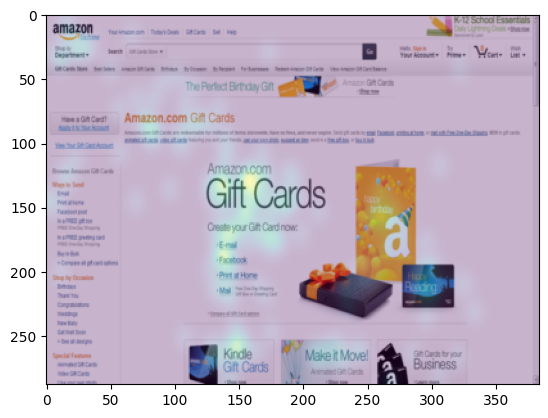

In [ ]:
plt.imshow(batch_samples[0].permute(1, 2, 0))
plt.imshow(batch_labels[0].permute(1, 2, 0), alpha=0.3)
plt.show()

# Test with a Random Model

In [ ]:
class RandomSaliencyModel(torch.nn.Module):

  def forward(self, x):
    """
    Return random array of size 1xHxW
    """
    bs = x.shape[0]
    return torch.rand((bs, 1, TRANSALNET_HEIGHT, TRANSALNET_WIDTH)) * 255

In [ ]:
model = RandomSaliencyModel()

# Validation loop

In [ ]:
# Validation
def valid_eval(model, loss_fn, valid_dl):
  running_vloss = 0

  with torch.no_grad():
      for i, vdata in enumerate(valid_dl):
          vinputs, vsmap, vfmap = vdata
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vsmap)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print(f"LOSS {avg_vloss}")


In [ ]:
loss_fn = torch.nn.MSELoss()
valid_dl = dl
valid_eval(model, loss_fn, valid_dl)

LOSS 21648.40625


# TranSalNet

In [ ]:
# coding=utf-8
# https://github.com/LJOVO/TranSalNet/blob/master/utils/TransformerEncoder.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math

from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu}


class Attention(nn.Module):
    def __init__(self, config):
        super(Attention, self).__init__()
        self.num_attention_heads = config["num_heads"]  # 12
        self.attention_head_size = int(config['hidden_size'] / self.num_attention_heads)    # 42
        self.all_head_size = self.num_attention_heads * self.attention_head_size    # 12*42=504

        self.query = Linear(config['hidden_size'], self.all_head_size)  # (512, 504)
        self.key = Linear(config['hidden_size'], self.all_head_size)
        self.value = Linear(config['hidden_size'], self.all_head_size)

        # self.out = Linear(config['hidden_size'], config['hidden_size'])
        self.out = Linear(self.all_head_size, config['hidden_size'])
        self.attn_dropout = Dropout(config["attention_dropout_rate"])
        self.proj_dropout = Dropout(config["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):

        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config['hidden_size'], config["mlp_dim"])
        self.fc2 = Linear(config["mlp_dim"], config['hidden_size'])
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config["dropout_rate"])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.flag = config['num_heads']
        self.hidden_size = config['hidden_size']
        self.ffn_norm = LayerNorm(config['hidden_size'], eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config)
        self.attention_norm = LayerNorm(config['hidden_size'], eps=1e-6)

    def forward(self, x):
        h = x

        x = self.attention_norm(x)
        x = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x


class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()

        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config['hidden_size'], eps=1e-6)
        for _ in range(config["num_layers"]):
            layer = Block(config)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        for layer_block in self.layer:
            hidden_states = layer_block(hidden_states)
        encoded = self.encoder_norm(hidden_states)

        return encoded


In [ ]:
cfg1 = {
"hidden_size" : 768,
"mlp_dim" : 768*4,
"num_heads" : 12,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}

cfg2 = {
"hidden_size" : 768,
"mlp_dim" : 768*4,
"num_heads" : 12,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}

cfg3 = {
"hidden_size" : 512,
"mlp_dim" : 512*4,
"num_heads" : 8,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}


class TranSalNet(nn.Module):

    def __init__(self):
        super(TranSalNet, self).__init__()
        self.encoder = _Encoder()
        self.decoder = _Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class _Encoder(nn.Module):
    def __init__(self):
        super(_Encoder, self).__init__()
        base_model = torchvision.models.resnet50(
            weights=torchvision.models.ResNet50_Weights.DEFAULT
            )
        base_layers = list(base_model.children())[:8]
        self.encoder = nn.ModuleList(base_layers).eval()

    def forward(self, x):
        outputs = []
        for ii,layer in enumerate(self.encoder):
            x = layer(x)
            if ii in {5,6,7}:
                outputs.append(x)
        return outputs


class _Decoder(nn.Module):

    def __init__(self):
        super(_Decoder, self).__init__()
        self.conv1 = nn.Conv2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(768, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv7 = nn.Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.batchnorm1 = nn.BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm4 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm5 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm6 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.TransEncoder1 = TransEncoder(in_channels=2048, spatial_size=9*12, cfg=cfg1)
        self.TransEncoder2 = TransEncoder(in_channels=1024, spatial_size=18*24, cfg=cfg2)
        self.TransEncoder3 = TransEncoder(in_channels=512, spatial_size=36*48, cfg=cfg3)

        self.add = torch.add
        self.relu = nn.ReLU(True)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x3, x4, x5 = x

        x5 = self.TransEncoder1(x5)
        x5 = self.conv1(x5)
        x5 = self.batchnorm1(x5)
        x5 = self.relu(x5)
        x5 = self.upsample(x5)

        x4_a = self.TransEncoder2(x4)
        x4 = x5 * x4_a
        x4 = self.relu(x4)
        x4 = self.conv2(x4)
        x4 = self.batchnorm2(x4)
        x4 = self.relu(x4)
        x4 = self.upsample(x4)

        x3_a = self.TransEncoder3(x3)
        x3 = x4 * x3_a
        x3 = self.relu(x3)
        x3 = self.conv3(x3)
        x3 = self.batchnorm3(x3)
        x3 = self.relu(x3)
        x3 = self.upsample(x3)

        x2 = self.conv4(x3)
        x2 = self.batchnorm4(x2)
        x2 = self.relu(x2)
        x2 = self.upsample(x2)
        x2 = self.conv5(x2)
        x2 = self.batchnorm5(x2)
        x2 = self.relu(x2)

        x1 = self.upsample(x2)
        x1 = self.conv6(x1)
        x1 = self.batchnorm6(x1)
        x1 = self.relu(x1)
        x1 = self.conv7(x1)
        x = self.sigmoid(x1)

        return x


class TransEncoder(nn.Module):

    def __init__(self, in_channels, spatial_size, cfg):
        super(TransEncoder, self).__init__()

        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,
                                          out_channels=cfg['hidden_size'],
                                          kernel_size=1,
                                          stride=1)
        self.position_embeddings = nn.Parameter(torch.zeros(1, spatial_size, cfg['hidden_size']))

        self.transformer_encoder = Encoder(cfg)

    def forward(self, x):
        a, b = x.shape[2], x.shape[3]
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)

        embeddings = x + self.position_embeddings
        x = self.transformer_encoder(embeddings)
        B, n_patch, hidden = x.shape
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, a, b)

        return x

In [ ]:
# Instantiate model
model = TranSalNet()

# Load weights
pretrained_weights = str(DATA_DIR / "Pretrained" / "TranSalNet_Res.pth")
model.load_state_dict(torch.load(pretrained_weights, map_location=torch.device('cpu')))

<All keys matched successfully>

# Splitting the data

In [ ]:
train_ds, val_ds = torch.utils.data.random_split(ds, [0.8, 0.2])

# Set batch size
bs = 4
n_workers = 4

# Instantiate data loaders
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=bs, shuffle=False, num_workers=n_workers)
val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=bs, shuffle=False, num_workers=n_workers)

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

TranSalNet(
  (encoder): _Encoder(
    (encoder): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
      

Output shape: torch.Size([1, 288, 384])


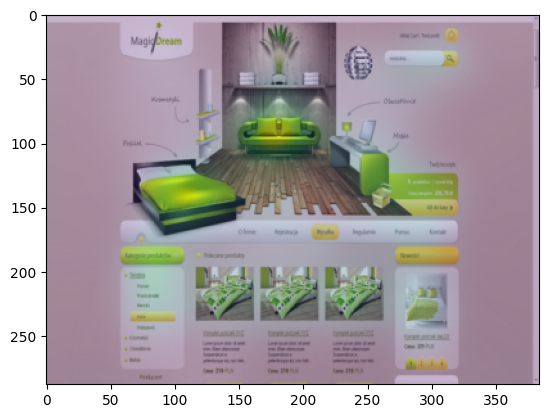

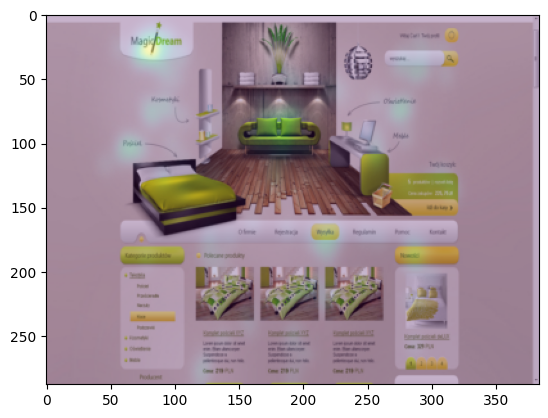

Loss 0.020133836194872856


In [ ]:
# Load the first batch from validation loader
batch_samples, batch_labels, batch_fmap = next(iter(val_dl))

batch_samples = batch_samples.to(device)
batch_labels = batch_labels.to(device)
batch_fmap = batch_fmap.to(device)

# Evalute on a single sample
out = model(batch_samples)
print(f"Output shape: {out[0].shape}")

# Visualize
plt.imshow(batch_samples[0].permute(1, 2, 0).cpu())
plt.imshow(out[0].permute(1, 2, 0).cpu().detach().numpy(), alpha=0.3)
plt.show()

# Compare with ground trouth
plt.imshow(batch_samples[0].permute(1, 2, 0).cpu())
plt.imshow(batch_labels[0].permute(1, 2, 0).cpu(), alpha=0.3)
plt.show()

# Evaluate loss of single instance
loss = loss_fn(out, batch_labels)
print(f"Loss {loss}")

# Loss functions

1. **CC (Correlation Coefficient):** It measures the linear relationship between two variables. In machine learning, it can be used as an evaluation metric for regression models to assess how well the predicted values match the actual values.

2. **KLD (Kullback-Leibler Divergence):** Also known as relative entropy, it measures how one probability distribution diverges from a second, expected probability distribution. It's commonly used in probabilistic models, information theory, and as a component in some types of generative models such as variational autoencoders (VAEs). (nn.KLDivLoss)

3. **NSS (Normalized Scanpath Saliency):** It's an evaluation metric in the field of visual attention modeling. NSS measures the correlation between predicted saliency maps and ground truth data of where humans fixate their gaze.

4. **SIM (Structural SIMilarity):** It's a metric used to assess the similarity between two images. It considers luminance, contrast, and structure similarity to evaluate how close two images are in terms of their visual content.

5. **sAUC (Segmentation Area Under the Curve):** This is an evaluation metric used in the context of image segmentation. It measures the area under the precision-recall curve to evaluate the performance of a segmentation model.

6. **AUC (Area Under Curve):**

In [ ]:
class SaliencyLoss(nn.Module):
    def __init__(self):
        super(SaliencyLoss, self).__init__()

    def forward(self, preds, labels, loss_type='cc'):
        losses = []
        if loss_type == 'cc':
            for i in range(labels.shape[0]): # labels.shape[0] is batch size
                loss = loss_CC(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'kldiv':
            for i in range(labels.shape[0]):
                loss = loss_KLdiv(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'sim':
            for i in range(labels.shape[0]):
                loss = loss_similarity(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'nss':
            for i in range(labels.shape[0]):
                loss = loss_NSS(preds[i],labels[i])
                losses.append(loss)

        return torch.stack(losses).mean(dim=0, keepdim=True)


def loss_KLdiv(pred_map, gt_map):
    eps = 2.2204e-16
    pred_map = pred_map/torch.sum(pred_map)
    gt_map = gt_map/torch.sum(gt_map)
    div = torch.sum(torch.mul(gt_map, torch.log(eps + torch.div(gt_map,pred_map+eps))))
    return div


def loss_CC(pred_map,gt_map):
    gt_map_ = (gt_map - torch.mean(gt_map))
    pred_map_ = (pred_map - torch.mean(pred_map))
    cc = torch.sum(torch.mul(gt_map_,pred_map_))/torch.sqrt(torch.sum(torch.mul(gt_map_,gt_map_))*torch.sum(torch.mul(pred_map_,pred_map_)))
    return cc


def loss_similarity(pred_map,gt_map):
    gt_map = (gt_map - torch.min(gt_map))/(torch.max(gt_map)-torch.min(gt_map))
    gt_map = gt_map/torch.sum(gt_map)

    pred_map = (pred_map - torch.min(pred_map))/(torch.max(pred_map)-torch.min(pred_map))
    pred_map = pred_map/torch.sum(pred_map)

    diff = torch.min(gt_map,pred_map)
    score = torch.sum(diff)

    return score


def loss_NSS(pred_map,fix_map):
    '''ground truth here is fixation map'''

    pred_map_ = (pred_map - torch.mean(pred_map))/torch.std(pred_map)
    mask = fix_map.gt(0)
    score = torch.mean(torch.masked_select(pred_map_, mask))
    return score

# Training loop

In [ ]:
# Create optimizer, scheduler, loss function
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_fn = SaliencyLoss()

In [ ]:
# Freeze weights
for name, param in model.named_parameters():
  if name.startswith("encoder"):
    param.requires_grad = False
  #print(f"{name}, requires_grad={param.requires_grad}")

In [ ]:
num_epochs = 10
best_loss = float("inf")

loss_dict = {"train_loss": [], "val_loss": []}
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    # Training
    model.train()
    running_loss = 0

    for i, batch in tqdm(enumerate(train_dl)):
      # Unpack batch and move to GPU
      stimuli, smap, fmap = batch
      stimuli, smap, fmap = stimuli.to(device), smap.to(device), fmap.to(device)

      # Forward
      optimizer.zero_grad()
      outputs = model(stimuli)
      loss = -2*loss_fn(outputs,smap,loss_type='cc')\
              -1*loss_fn(outputs,smap,loss_type='sim')+\
              10*loss_fn(outputs,smap,loss_type='kldiv')\
              -1*loss_fn(outputs,fmap,loss_type='nss')

      # Backward
      loss.backward()
      optimizer.step()

      # Track statistics
      running_loss += loss.item()* stimuli.size(0)

    # Take scheduler step after batches
    #scheduler.step()

    # Track training epoch loss
    epoch_loss = running_loss/len(train_ds)

    # Validation
    model.eval()
    running_vloss = 0
    for i, batch in tqdm(enumerate(val_dl)):

      # Unpack batch and move to GPU
      stimuli, smap, fmap = batch
      stimuli, smap, fmap = stimuli.to(device), smap.to(device), fmap.to(device)

      # Forward
      with torch.no_grad():
        outputs = model(stimuli)
        vloss = -2*loss_fn(outputs,smap,loss_type='cc')\
                -1*loss_fn(outputs,smap,loss_type='sim')+\
                10*loss_fn(outputs,smap,loss_type='kldiv')\
                -1*loss_fn(outputs,fmap,loss_type='nss')

      # Track statistics
      running_vloss += vloss.item()* stimuli.size(0)

    epoch_vloss = running_vloss/len(val_ds)

    loss_dict["train_loss"].append(epoch_loss)
    loss_dict["val_loss"].append(epoch_vloss)

    # Save most recent model and best model
    torch.save(model.state_dict(), SAVE_RECENT_FILE)
    if epoch_vloss < best_loss:
      best_loss = epoch_vloss
      torch.save(model.state_dict(), SAVE_BEST_FILE)

    print(f"Train loss {epoch_loss:.4f} Val loss {epoch_vloss:.4f}")

print('Best val loss: {:4f}'.format(best_loss))

Epoch 1/10
----------


30it [00:13,  2.28it/s]
8it [00:01,  4.31it/s]


Train loss 7.9648 Val loss 5.8253
Epoch 2/10
----------


30it [00:13,  2.29it/s]
8it [00:01,  4.23it/s]


Train loss 4.8751 Val loss 4.0400
Epoch 3/10
----------


30it [00:12,  2.38it/s]
8it [00:01,  4.08it/s]


Train loss 3.2122 Val loss 2.9447
Epoch 4/10
----------


30it [00:12,  2.31it/s]
8it [00:03,  2.34it/s]


Train loss 2.3047 Val loss 2.6030
Epoch 5/10
----------


30it [00:12,  2.39it/s]
8it [00:02,  3.40it/s]


Train loss 1.7812 Val loss 2.3787
Epoch 6/10
----------


30it [00:13,  2.26it/s]
8it [00:02,  3.89it/s]


Train loss 1.3053 Val loss 2.2434
Epoch 7/10
----------


30it [00:12,  2.36it/s]
8it [00:01,  4.17it/s]


Train loss 0.8056 Val loss 2.2358
Epoch 8/10
----------


30it [00:12,  2.32it/s]
8it [00:02,  3.03it/s]


Train loss 0.2540 Val loss 2.3632
Epoch 9/10
----------


30it [00:12,  2.38it/s]
8it [00:01,  4.20it/s]


Train loss -0.3560 Val loss 2.6205
Epoch 10/10
----------


30it [00:13,  2.30it/s]
8it [00:01,  4.04it/s]


Train loss -0.9932 Val loss 2.9539
Best val loss: 2.235758


Text(0, 0.5, 'loss')

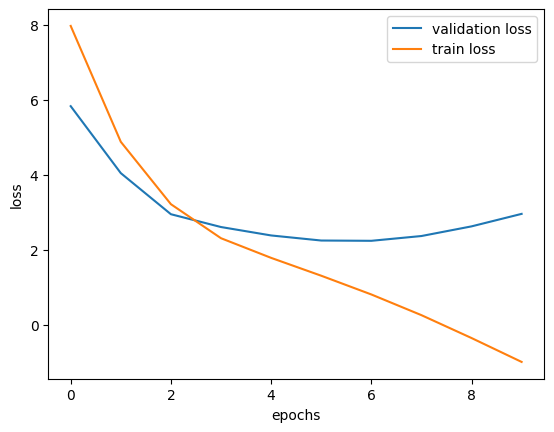

In [ ]:
plt.plot(loss_dict["val_loss"], label = "validation loss")
plt.plot(loss_dict["train_loss"], label = "train loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")


Output shape: torch.Size([1, 288, 384])


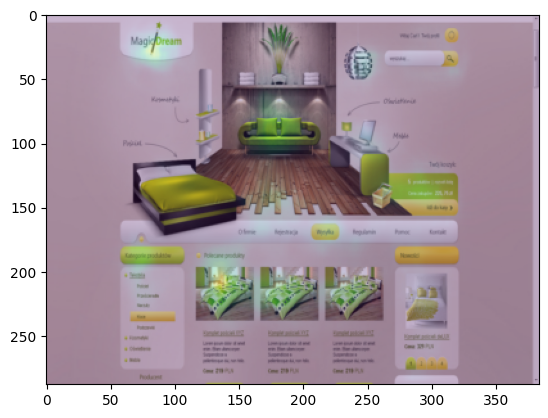

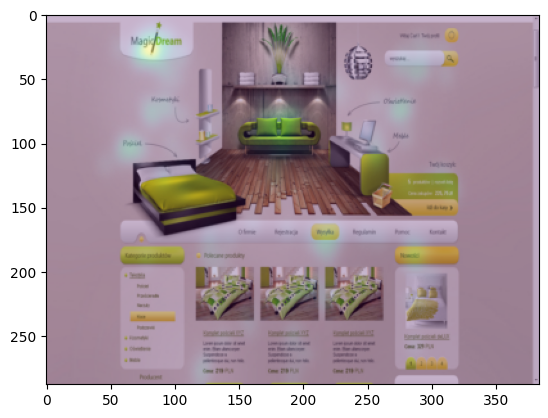

Loss tensor([0.6559], device='cuda:0', grad_fn=<MeanBackward1>)


In [ ]:
# Load the first batch from validation loader
batch_samples, batch_labels, batch_fmap = next(iter(val_dl))

batch_samples, batch_labels, batch_fmap = batch_samples.to(device), batch_labels.to(device), batch_fmap.to(device)

# Evalute on a single sample
out = model(batch_samples)
print(f"Output shape: {out[0].shape}")

# Visualize
plt.imshow(batch_samples[0].permute(1, 2, 0).cpu())
plt.imshow(out[0].permute(1, 2, 0).cpu().detach().numpy(), alpha=0.3)
plt.show()

# Compare with ground trouth
plt.imshow(batch_samples[0].permute(1, 2, 0).cpu())
plt.imshow(batch_labels[0].permute(1, 2, 0).cpu(), alpha=0.3)
plt.show()

# Evaluate loss of single instance
loss = loss_fn(out, batch_labels, loss_type="cc")
print(f"Loss {loss}")